In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import pandas as pd
import pickle
from torch.utils.data import RandomSampler
import random
import scipy
import torch.nn.functional as F
from PIL import Image
from glob import glob
import wandb
import re
from adjustText import adjust_text
import seaborn as sns
import scipy
import statannot
import argparse
import sys
sys.path.append('../../modified_medsam_repo')

In [7]:
pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df_new/1/0.001/isolated_path_df_constant_bbox.csv')

,id,slice,image_embedding_slice_path,segmentation_slice_path,image_path,bbox_0,bbox_1,bbox_2,bbox_3
0,100206,15,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,0,0,256,256
1,100206,78,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,0,0,256,256
2,100206,79,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,0,0,256,256
3,100206,80,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,0,0,256,256
4,100206,81,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,0,0,256,256
...,...,...,...,...,...,...,...,...,...
121162,996782,185,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,0,0,256,256
121163,996782,186,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,0,0,256,256
121164,996782,187,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,0,0,256,256
121165,996782,188,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,0,0,256,256


<Axes: xlabel='data', ylabel='model'>

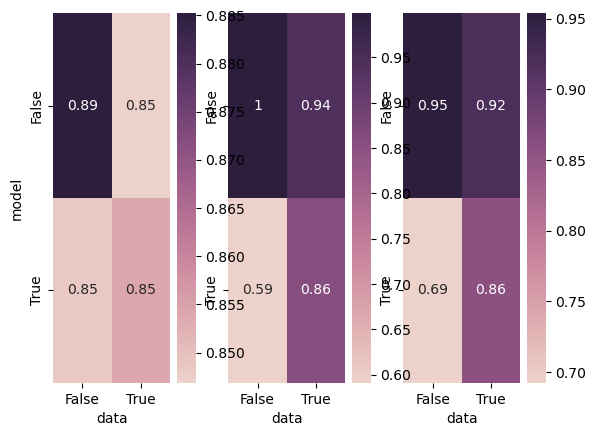

In [20]:
opts = ['m-_d-', 'm-_d+', 'm+_d-', 'm+_d+']
#opts = ['m-_d-', 'm-_d+', 'm+_d+']
listo = []
for x in opts:
    path = f'/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/unet_compare_dataset_types_9-3-24/{x}/eval_singletask_unet_val_label5.pkl'
    yy = pd.read_pickle(path)
    yy['dice_sensitivity'] = yy['dice_sensitivity'].item()
    yy['dice_specificity'] = yy['dice_specificity'].item()
    yy['overall_dice'] = yy['overall_dice'].item()
    del yy['label_numbers']
    if 'm-' in x:
        yy['model'] = False
    else:
        yy['model'] = True
    
    if 'd-' in x:
        yy['data'] = False
    else:
        yy['data'] = True

    listo.append(yy)

df = pd.DataFrame(listo)

fig, axs = plt.subplots(1,3)
sns.heatmap(df.pivot(index='model', columns='data', values='dice_sensitivity'), ax=axs[0], cmap=sns.cubehelix_palette(as_cmap=True), annot=True)
sns.heatmap(df.pivot(index='model', columns='data', values='dice_specificity'), ax=axs[1], cmap=sns.cubehelix_palette(as_cmap=True), annot=True)
sns.heatmap(df.pivot(index='model', columns='data', values='overall_dice'), ax=axs[2], cmap=sns.cubehelix_palette(as_cmap=True), annot=True)

In [18]:
#pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_unet.csv').shape[0]  
#pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df/baseline_unet/all_labels_df.csv') # only 79...186 = 1...108
444 * 108/256

187.3125

In [ ]:
# may need to also run with label=1 because then there's almost no blank slices

### compare multiple levels of adding blanks

In [25]:
dicto = {'label':[], 'frac':[], 'dice_sensitivity':[], 'dice_specificity':[], 'overall_dice':[]}
for label in [1,5,18,58]:
    for frac in [0, 0.001, 0.01, 0.1,  0.05, 0.25, 1]:
        path = f'/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/unet_compare_blank_training_9-6-24/val/{label}/{frac}/eval_singletask_unet_val_label{label}.pkl'
        if not os.path.exists(path):
            continue

        xx = pd.read_pickle(path)
        
        dicto['label'].append(label)
        dicto['frac'].append(frac)
        dicto['dice_sensitivity'].append(xx['dice_sensitivity'].item())
        dicto['dice_specificity'].append(xx['dice_specificity'].item())
        dicto['overall_dice'].append(xx['overall_dice'].item())

df = pd.DataFrame(dicto)
df

,label,frac,dice_sensitivity,dice_specificity,overall_dice
0,1,0.000,0.931517,0.763661,0.834115
1,1,0.001,0.933852,0.949057,0.942675
2,1,0.010,0.937532,0.985869,0.965581
3,1,0.100,0.895452,0.996846,0.954288
4,1,0.050,0.941773,0.983868,0.966199
5,1,0.250,0.921772,0.999090,0.966637
6,1,1.000,0.849586,0.995755,0.934404
7,5,0.000,0.882652,0.928301,0.917425
8,5,0.001,0.885467,0.929456,0.918976
9,5,0.010,0.883189,0.959207,0.941096


<Figure size 7680x5760 with 0 Axes>

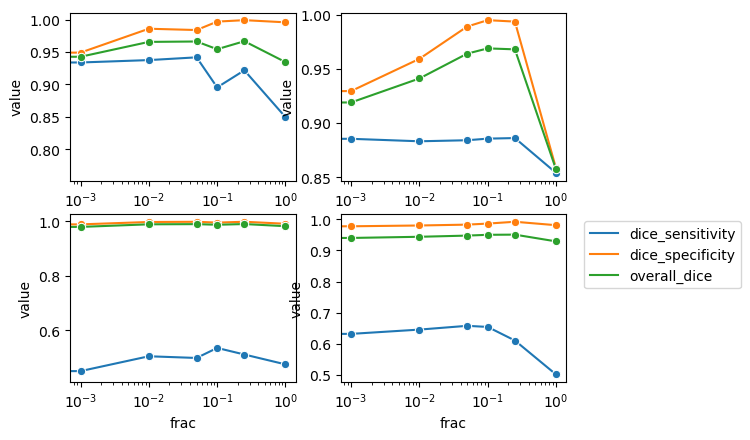

In [26]:
def plot_for_label(label_num, ax):
    subdf = df[df['label'] == label_num].reset_index(drop=True)
    dfmelt = pd.melt(subdf, id_vars=['label', 'frac'], value_vars = ['dice_sensitivity', 'dice_specificity', 'overall_dice'])
    sns.lineplot(dfmelt, x='frac', y='value', hue='variable', marker='o', ax=ax)
    ax.set(xscale='log')
plt.figure(dpi=1200)
fig, axs = plt.subplots(2,2)
plot_for_label(1, axs[0,0])
plot_for_label(5, axs[0,1])
plot_for_label(18, axs[1,0])
plot_for_label(58, axs[1,1])

axs[0,0].get_legend().remove()
axs[0,1].get_legend().remove()
axs[1,0].get_legend().remove()
axs[1,1].get_legend().remove()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('/gpfs/home/kn2347/figs/comparing_blank_trained.png')   